### Loading necessary libraries (pandas, matplotlib)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

### Loading and sorting the original dataset

In [2]:
df = pd.read_csv('orders.csv')

In [3]:
# Change the format of the column "date"
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [4]:
# Sort the dataset in descending order by date
df= df.sort_values(by='date', ascending=False)
# Remove duplicate invoices
df = df.drop_duplicates(subset='InvoiceId')
df.head(10)

,date,CustomerId,country,InvoiceId,SKU,productPrice,productQuantity
1286734,2022-03-17,0xcPZa4/LE/mLcwh3sY8qQ==,Italy,Y58OjBdWFko4aOS/w2rWJg==,kX00C83/MbxwSUrAhl5G3w==,10.19,1
3575015,2022-03-17,5Zthk91X4guopgu26Bcn6g==,Mozambique,PpPvi9JOncaly6dFlUOpDw==,U/EJb58YXdxQqk19XxtSXA==,23.97,12
270794,2022-03-17,CcX6OhTiLaIgELqd1z+0Kw==,France,F03IrXut+S11SaaTPVwd9A==,Lfjws/JhrpyRoHlYRUMxtg==,20.97,2
742856,2022-03-17,so4jpRsAZKQx34MZOxChDw==,France,23mNfmBU+z1N1JmldraEgA==,gkh0RAUtlD0VaIUHDHGg0w==,5.99,1
3301761,2022-03-17,UHrST3r/07A4Fx+EmBGVMA==,France,rPn3NCeownJ2uEWusYahuQ==,we5PrOnsGbAH2YbAmtNMbQ==,17.97,2
1854281,2022-03-17,r7yhZArVnx2UsjtVBosXmA==,Italy,i6jmAjnvu8PWVNtdFfa/mA==,CcMJ2gRS7yCd551qKY7LUg==,14.98,1
388539,2022-03-17,IXYfginqnJzoWQwJSAjjNQ==,France,0jbXhCL4cqvyKyJEb1PuNw==,/ZbUMwpxtog/UB5FmESKFA==,5.24,1
3958513,2022-03-17,lEn3YiqhoN5zlWj4lFegyQ==,Italy,7gM7zzhELTOaf2MoXnp1JA==,CcMJ2gRS7yCd551qKY7LUg==,29.97,2
3388584,2022-03-17,XjFYzxqkz+CxF0WLz4Ooig==,Spain,z1FOIxPyAx0rY+4A9BhE/A==,d5YvsykEq4HMp6NezWNS+w==,29.97,2
617493,2022-03-17,LI3wDmo8lWROZs4O/NThRw==,Austria,acBMAyVu91FgPfZ+KdU8bg==,cc0Q1y0uyEzxaDC9eAtt4w==,3.15,1


In [5]:
# Count the number of orders by country
df.country.value_counts()

country
France                   240777
Italy                    226870
Spain                     73389
Ukraine                   58396
United Kingdom            38700
                          ...  
St. Pierre & Miquelon         1
Sierra Leone                  1
Anguilla                      1
Myanmar (Burma)               1
South Sudan                   1
Name: count, Length: 197, dtype: int64

In [6]:
# Check the type of the columns
df.dtypes

date               datetime64[ns]
CustomerId                 object
country                    object
InvoiceId                  object
SKU                        object
productPrice              float64
productQuantity             int64
dtype: object

### RFM Calculation (RFM stands for Recency, Frequency, Monetary)

#### Recency

In [7]:
# Define the reference day (the last date recorded in the original dataset is "2022-17-03")
day = pd.to_datetime('2022-04-01')

# Calculate Recency value (The number of days after customers' latest order)
recency = df.groupby('CustomerId').agg(
    recency_days=pd.NamedAgg(column='date', aggfunc=lambda x: (day - x.max()).days)
)
recency

,recency_days
CustomerId,
+++SJgx/2IJ+dXq7vF8COg==,124
+++aKiAiXhTfaqCLC/kyWA==,381
++/G67YHZTMKdpvANeYPLw==,442
++/GTDXvJzF11ZIUz81SPg==,217
++0Dxza60/nPDbfORBYuuA==,34
...,...
zzyyHmcBdlPu2LT05kFnrQ==,247
zzz2aWARN6OJELfdgOZpWw==,50
zzzCCNCA1718e2kRryHpJQ==,380


#### Frequency

In [8]:
# Calculate frequency of invoices per customer
freq = df.groupby(["CustomerId"])[["InvoiceId"]].count()

freq

,InvoiceId
CustomerId,
+++SJgx/2IJ+dXq7vF8COg==,1
+++aKiAiXhTfaqCLC/kyWA==,1
++/G67YHZTMKdpvANeYPLw==,1
++/GTDXvJzF11ZIUz81SPg==,1
++0Dxza60/nPDbfORBYuuA==,1
...,...
zzyyHmcBdlPu2LT05kFnrQ==,1
zzz2aWARN6OJELfdgOZpWw==,1
zzzCCNCA1718e2kRryHpJQ==,1


#### Monetary

In [9]:
# The value of each order can be calculated by looking at the production of "productPrice" and "productQuantity"
df["total"]=df["productPrice"]*df["productQuantity"]

# Find the total money payed by each customer
money=df.groupby(["CustomerId"])[["total"]].sum()

money

,total
CustomerId,
+++SJgx/2IJ+dXq7vF8COg==,107.85
+++aKiAiXhTfaqCLC/kyWA==,11.98
++/G67YHZTMKdpvANeYPLw==,33.54
++/GTDXvJzF11ZIUz81SPg==,41.94
++0Dxza60/nPDbfORBYuuA==,53.88
...,...
zzyyHmcBdlPu2LT05kFnrQ==,60.00
zzz2aWARN6OJELfdgOZpWw==,143.76
zzzCCNCA1718e2kRryHpJQ==,23.94


In [10]:
# Change the name of each column of each dataset
recency.columns=["Recency"]
freq.columns=["Frequency"]
money.columns=["Monetary"]

In [11]:
# Put all three dataset into one merged dataset 
RFM=pd.concat([recency,freq,money], axis=1)
RFM

,Recency,Frequency,Monetary
CustomerId,,,
+++SJgx/2IJ+dXq7vF8COg==,124,1,107.85
+++aKiAiXhTfaqCLC/kyWA==,381,1,11.98
++/G67YHZTMKdpvANeYPLw==,442,1,33.54
++/GTDXvJzF11ZIUz81SPg==,217,1,41.94
++0Dxza60/nPDbfORBYuuA==,34,1,53.88
...,...,...,...
zzyyHmcBdlPu2LT05kFnrQ==,247,1,60.00
zzz2aWARN6OJELfdgOZpWw==,50,1,143.76
zzzCCNCA1718e2kRryHpJQ==,380,1,23.94


### Find optimal number of clusters using Elbow method

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

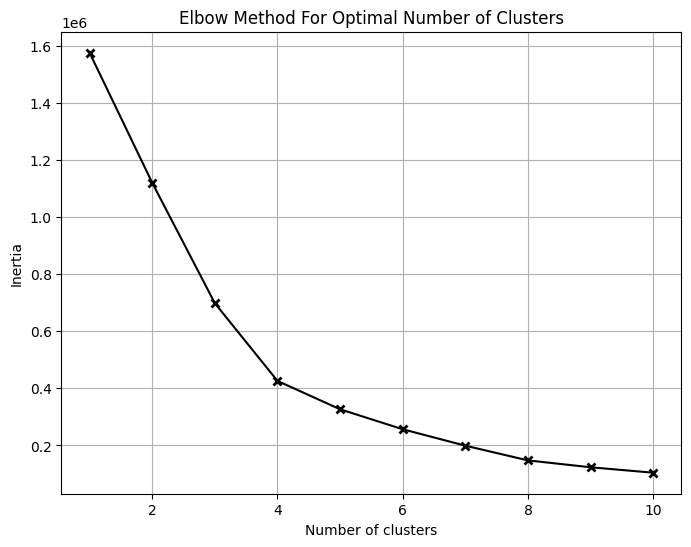

In [12]:
# Select features for clustering
features = RFM[['Frequency', 'Recency', 'Monetary']]

# Scale the dataset
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# Elbow method to find the optimal number of clusters
inertia = []
range_n_clusters = range(1, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6), facecolor='white')  # Set the background color to white
plt.plot(range_n_clusters, inertia, marker='x', linestyle='-', color='black', markerfacecolor='white', markeredgewidth=2, markeredgecolor='black')
plt.xlabel('Number of clusters', color='black')  # Set the color of x-axis label to black
plt.ylabel('Inertia', color='black')  # Set the color of y-axis label to black
plt.title('Elbow Method For Optimal Number of Clusters', color='black')  # Set the color of title to black
plt.grid(True)  # Add gridlines
plt.show()


### Clustering customers using Kmeans

In [13]:
# Accoring to the Elbow method, the optimal number of clusters is 4
kmeans=KMeans(n_clusters=4)
kmeans.fit(scaled)
# Add the column "Clusters" with assigned cluster for each customer
RFM["Clusters"]=(kmeans.labels_)
RFM

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Recency,Frequency,Monetary,Clusters
CustomerId,,,,
+++SJgx/2IJ+dXq7vF8COg==,124,1,107.85,0
+++aKiAiXhTfaqCLC/kyWA==,381,1,11.98,1
++/G67YHZTMKdpvANeYPLw==,442,1,33.54,1
++/GTDXvJzF11ZIUz81SPg==,217,1,41.94,0
++0Dxza60/nPDbfORBYuuA==,34,1,53.88,0
...,...,...,...,...
zzyyHmcBdlPu2LT05kFnrQ==,247,1,60.00,1
zzz2aWARN6OJELfdgOZpWw==,50,1,143.76,0
zzzCCNCA1718e2kRryHpJQ==,380,1,23.94,1


In [14]:
# Calculate the mean of Recency, Frequency, Monetary of each cluster
group=RFM.groupby(["Clusters"])[["Recency", "Frequency", "Monetary"]].mean()
group

,Recency,Frequency,Monetary
Clusters,,,
0,106.515722,1.804270,8.841492e+02
1,354.668899,1.164542,1.703159e+02
2,123.000000,1676.000000,4.044394e+07
3,53.925926,518.333333,2.593540e+06


In [29]:
# Categorize the clusters 
def func(row):
    if row["Clusters"]==0:
        return "Quite new - Little freq - Little pay"
    elif row["Clusters"]==2:
        return "Little old - High freq - High pay"
    elif row["Clusters"]==3:
        return "New - Quite freq - Quite high pay "
    else:
        return "Old - Least frequent - Pay least "

In [30]:
RFM["Category"]=RFM.apply(func, axis=1)
RFM

,Recency,Frequency,Monetary,Clusters,Category
CustomerId,,,,,
+++SJgx/2IJ+dXq7vF8COg==,124,1,107.85,0,Quite new - Little freq - Little pay
+++aKiAiXhTfaqCLC/kyWA==,381,1,11.98,1,Old - Least frequent - Pay least
++/G67YHZTMKdpvANeYPLw==,442,1,33.54,1,Old - Least frequent - Pay least
++/GTDXvJzF11ZIUz81SPg==,217,1,41.94,0,Quite new - Little freq - Little pay
++0Dxza60/nPDbfORBYuuA==,34,1,53.88,0,Quite new - Little freq - Little pay
...,...,...,...,...,...
zzyyHmcBdlPu2LT05kFnrQ==,247,1,60.00,1,Old - Least frequent - Pay least
zzz2aWARN6OJELfdgOZpWw==,50,1,143.76,0,Quite new - Little freq - Little pay
zzzCCNCA1718e2kRryHpJQ==,380,1,23.94,1,Old - Least frequent - Pay least


In [31]:
# Count the number of customers of each category
result=RFM["Category"].value_counts()
result

Category
Quite new - Little freq - Little pay    297864
Old - Least frequent - Pay least        227450
New - Quite freq - Quite high pay           27
Little old - High freq - High pay            1
Name: count, dtype: int64

In [32]:
# Create an interactive bar chart 
fig = px.bar(result, x='count', orientation='h',
             log_x=True,  # Logarithmic scale for x-axis
             title='Counts by Condition',
             template='plotly_white')  # Set background color to white
fig.show()

### Clustering customers by divining customers into tiers

In [33]:
# Selecting only the first 3 columns of the RFM dataset
RFM2 = RFM.iloc[:, 0:3]
RFM2

,Recency,Frequency,Monetary
CustomerId,,,
+++SJgx/2IJ+dXq7vF8COg==,124,1,107.85
+++aKiAiXhTfaqCLC/kyWA==,381,1,11.98
++/G67YHZTMKdpvANeYPLw==,442,1,33.54
++/GTDXvJzF11ZIUz81SPg==,217,1,41.94
++0Dxza60/nPDbfORBYuuA==,34,1,53.88
...,...,...,...
zzyyHmcBdlPu2LT05kFnrQ==,247,1,60.00
zzz2aWARN6OJELfdgOZpWw==,50,1,143.76
zzzCCNCA1718e2kRryHpJQ==,380,1,23.94


In [34]:
# Define the quantiles based on the provided summary statistics
recency_quantiles = RFM2['Recency'].quantile([0.25, 0.5, 0.75]).tolist()
frequency_quantiles = RFM2['Frequency'].quantile([0.25, 0.5, 0.75]).tolist()
monetary_quantiles = RFM2['Monetary'].quantile([0.25, 0.5, 0.75]).tolist()

In [35]:
print(recency_quantiles)
print(frequency_quantiles)
print(monetary_quantiles)

[93.0, 184.0, 346.0]
[1.0, 1.0, 1.0]
[13.63, 41.94, 132.0]


In [36]:
# Define functions to map R, F, M to tiers based on quantiles
def recency_tier(recency):
    if recency <= recency_quantiles[0]:
        return 1
    elif recency <= recency_quantiles[1]:
        return 2
    elif recency <= recency_quantiles[2]:
        return 3
    else:
        return 4

def frequency_tier(frequency):
    if frequency <= frequency_quantiles[0]:
        return 4
    elif frequency <= frequency_quantiles[1]:
        return 3
    elif frequency <= frequency_quantiles[2]:
        return 2
    else:
        return 1

def monetary_tier(monetary):
    if monetary <= monetary_quantiles[0]:
        return 4
    elif monetary <= monetary_quantiles[1]:
        return 3
    elif monetary <= monetary_quantiles[2]:
        return 2
    else:
        return 1

In [37]:
# Apply the functions to the DataFrame
RFM2['R_Tier'] = RFM2['Recency'].apply(recency_tier)
RFM2['F_Tier'] = RFM2['Frequency'].apply(frequency_tier)
RFM2['M_Tier'] = RFM2['Monetary'].apply(monetary_tier)

In [38]:
# Define the segments of the customers
def customer_segment(row):
    if (row['R_Tier'] == 1) & (row['F_Tier'] == 1) & (row['M_Tier'] == 1):
        return 'Best Customers'
    elif (row['R_Tier'] == 1) & (row['F_Tier'] == 4) & (row['M_Tier'] == 2) | (row['M_Tier'] == 1):
        return 'High-spending New Customers'
    elif (row['R_Tier'] == 1) & (row['F_Tier'] == 1) & ((row['M_Tier'] == 3) | (row['M_Tier'] == 4)):
        return 'Lowest-Spending Active Loyal Customers'
    elif (row['R_Tier'] == 4) & ((row['F_Tier'] == 1) | (row['F_Tier'] == 2)) & ((row['M_Tier'] == 1) | (row['M_Tier'] == 2)):
        return 'Churned Best Customers'
    else:
        return 'Other'

In [39]:
# Apply the function to the RFM2 dataset
RFM2['Segment'] = RFM2.apply(customer_segment, axis=1)

In [40]:
RFM2

,Recency,Frequency,Monetary,R_Tier,F_Tier,M_Tier,Segment
CustomerId,,,,,,,
+++SJgx/2IJ+dXq7vF8COg==,124,1,107.85,2,4,2,Other
+++aKiAiXhTfaqCLC/kyWA==,381,1,11.98,4,4,4,Other
++/G67YHZTMKdpvANeYPLw==,442,1,33.54,4,4,3,Other
++/GTDXvJzF11ZIUz81SPg==,217,1,41.94,3,4,3,Other
++0Dxza60/nPDbfORBYuuA==,34,1,53.88,1,4,2,High-spending New Customers
...,...,...,...,...,...,...,...
zzyyHmcBdlPu2LT05kFnrQ==,247,1,60.00,3,4,2,Other
zzz2aWARN6OJELfdgOZpWw==,50,1,143.76,1,4,1,High-spending New Customers
zzzCCNCA1718e2kRryHpJQ==,380,1,23.94,4,4,3,Other


In [41]:
# Count the number of each segment
segment_counts = RFM2['Segment'].value_counts()
# Reset index to make 'Segment' a column
segment_counts= segment_counts.reset_index()
# Rename columns 
segment_counts.columns = ['Segment', 'Count']
segment_counts

,Segment,Count
0,Other,363399
1,High-spending New Customers,123749
2,Best Customers,25233
3,Lowest-Spending Active Loyal Customers,9773
4,Churned Best Customers,3188


In [42]:
# Create the bar chart
fig = px.bar(segment_counts, x='Segment', y='Count', orientation='v',
             title='Counts by Segment',
             template='plotly_white')  # Set background color to white

# Update layout to change the height of the plot
fig.update_layout(
    height=600  # Specify the height in pixels
)

# Show the plot
fig.show()